# Setup 

In [6]:
# setup random indicies
import numpy as np

np.random.seed(9)

house_ids = range(1,1461)
random_id = np.random.choice(house_ids, 1460, replace = False)


# load df
import pandas as pd
df = pd.read_csv("../data/train_model.csv")

# randomized index
df.drop(columns = ['Unnamed: 0', 'Id'], inplace = True)
df['random_id'] = random_id
df.set_index('random_id', inplace = True)
df.sort_index(inplace=True)
df.head(5)

# remove outliers
df.drop([907, 465], inplace=True)

# log transform SalePrice
df['SalePrice'] = np.log(df.SalePrice)

df.head(2)

,LotFrontage,LotArea,YearBuilt,GrLivArea,YrSold,SalePrice,MSZoning_RL,MSZoning_RMH,Alley_NoAccess,LotShape_Regular,...,OpenPorchSF_OpenPorch_Yes,Fence_no_fence,MoSold_peak_months,SaleType_non_deed,SaleCondition_not_normal,IsVinyl_yes,FullBaths_<=1FullBath,FullBaths_>=3FullBaths,HalfBaths_>=1HalfBaths,Enclosed_combined_EnclosedPorch_Yes
random_id,,,,,,,,,,,,,,,,,,,,,
1,87.0,9246,37,1656,2008,11.813030,1,0,1,0,...,1,1,0,0,0,0,0,0,0,0
2,60.0,7200,60,1904,2009,11.835009,1,0,1,1,...,0,0,1,0,0,1,0,0,1,1


In [12]:
#Import and prep test data
df_test_X = pd.read_csv("../data/test_model.csv")
df_test = df_test_X.copy()
df_test_ids = df_test.Id
df_test.drop(columns = ['Unnamed: 0', 'Id'], inplace = True)
df_test.head(2)

,LotFrontage,LotArea,YearBuilt,GrLivArea,YrSold,MSZoning_RL,MSZoning_RMH,Alley_NoAccess,LotShape_Regular,LandContour_Unflat,...,OpenPorchSF_OpenPorch_Yes,Fence_no_fence,MoSold_peak_months,SaleType_non_deed,SaleCondition_not_normal,IsVinyl_yes,FullBaths_<=1FullBath,FullBaths_>=3FullBaths,HalfBaths_>=1HalfBaths,Enclosed_combined_EnclosedPorch_Yes
0,80.0,11622,49,896,2010,0,1,1,1,0,...,0,0,1,0,0,1,1,0,0,1
1,81.0,14267,52,1329,2010,1,0,1,0,0,...,1,1,1,0,0,0,1,0,1,0


# Model 1: Saturated/Full
This model generates a coefficient for all features. We anticipate this to be an ovefit model but is a starting point to evaluate the efficacy of our feature engineering efforts.

In [8]:
from sklearn import linear_model
import statsmodels.api as sm

ols = linear_model.LinearRegression()

# Fit model using full training set
X_train = df.drop(['SalePrice'], axis = 1)
y_train = df.SalePrice

X_train = sm.add_constant(X_train) 
model_1 = sm.OLS(y_train, X_train)
model_1_fit = model_1.fit()
print(model_1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     195.8
Date:                Sat, 02 Jun 2018   Prob (F-statistic):               0.00
Time:                        13:14:45   Log-Likelihood:                 988.87
No. Observations:                1458   AIC:                            -1840.
Df Residuals:                    1389   BIC:                            -1475.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### Predicting SalePrice in test df using Saturated Linear Model

In [4]:
#fit and predict
ols.fit(df.drop(['SalePrice'], axis = 1), y_train)
df_test['SalePrice']= np.exp(ols.predict(df_test)).round()
df_test['Id'] = df_test_ids

#ship for scoring
model_1_submission = df_test.loc[:,['Id', 'SalePrice']]
model_1_submission.to_csv("../predictions/model_1_submission.csv", index = False)
print("Model_1 printed!")

Model_1 printed!


### Kaggle result
RMSE: 0.13825  
Rank: 2081

# Model 2: Agressive Univariate (KBest, f_regressor) Feature Selection
First attempt at stepwise feature selection. There appeared to be 2 inflection points in the KBest iterative feature figure. Model 2 (agressively) seeks a parsimonious model by selecting for 28 features in these first 2 regions.

In [5]:
import sklearn.feature_selection as fs

#setup stepwise selection using KBest, f_regression
k28_features = fs.SelectKBest(fs.f_regression, k=28)
k28_features.fit(X_train, y_train)

#grab column indicies for best 28
idxs = k28_features.get_support(indices=True).tolist()

#evaluate
model_2 = sm.OLS(y_train, X_train.iloc[:,idxs])
model_2_fit = model_2.fit()
print(model_2_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3161.
Date:                Fri, 01 Jun 2018   Prob (F-statistic):               0.00
Time:                        21:59:29   Log-Likelihood:                -2676.5
No. Observations:                1458   AIC:                             5409.
Df Residuals:                    1430   BIC:                             5557.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
LotFrontage 

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


### Predicting SalePrice in test df using Univarate Feature Selection

In [8]:
df_test.iloc[:,idxs].head(5)

,LotArea,GrLivArea,YrSold,Alley_NoAccess,Neighborhood_SAmes,OverallQual_LowQ,OverallCond_BadC,ExterQual_low,ExterCond_low,BsmtQual_low,...,GarageType_Detached,GarageFinish_GarageUnf,GarageFinish_NoGarageFin,GarageCars_2.0,GarageQual_GarageQual_not_good,GarageCond_GarageCond_not_good,PavedDrive_Y,Fence_no_fence,FullBaths_>=3FullBaths,HalfBaths_>=1HalfBaths
0,11622,896,2010,1,0,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,0
1,14267,1329,2010,1,0,0,0,1,1,1,...,0,1,0,0,0,0,1,1,0,1
2,13830,1629,2010,1,0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,0,1
3,9978,1604,2010,1,0,0,0,1,1,1,...,0,0,0,1,0,0,1,1,0,1
4,5005,1280,2010,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,0


In [11]:
#fit and predict
ols.fit(df.drop(['SalePrice'], axis = 1).iloc[:,idxs], y_train)


df_test['SalePrice']= np.exp(ols.predict(df_test.iloc[:,idxs])).round()
df_test['Id'] = df_test_ids

#ship for scoring
model_2_submission = df_test.loc[:,['Id', 'SalePrice']]
model_2_submission.to_csv("../predictions/model_2_submission.csv", index = False)
print("Model_2 printed!")

Model_2 printed!


### Kaggle result
RMSE: 0.17350  
Rank: n/a, did not improve score

# Model 3: LM with Lasso Regularization
Based on the univariate model, lasso regularization will drop some number of features that reduces prediction bias.  
Model 2 indicated that 28 features was not a good stopping point (based on Kaggle result with holdout RMSE).  
How many features will remain after Lasso Regularization?

In [9]:
lasso = linear_model.Lasso(alpha=0.0011497569953977356,random_state=9)
lasso.fit(df.drop(['SalePrice'],axis=1),df.SalePrice)

Lasso(alpha=0.0011497569953977356, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=9, selection='cyclic', tol=0.0001, warm_start=False)

### Predicting SalePrice in test df using Lasso Regularization

In [21]:
#lasso.predict(df_test)
#df_test['SalePrice'] = np.exp(lasso.predict(df_test)).round()
print(df_test.columns)
df_test_X.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'GrLivArea', 'YrSold',
       'MSZoning_RL', 'MSZoning_RMH', 'Alley_NoAccess', 'LotShape_Regular',
       'LandContour_Unflat', 'LotConfig_CulDSac', 'LotConfig_Inside',
       'LandSlope_NGtl', 'Neighborhood_NAmes', 'Neighborhood_SAmes',
       'Condition1_NormP', 'BldgType_OneFamily', 'BldgType_Townhouse',
       'HouseStyle_OneStoryUp', 'OverallQual_HighQ', 'OverallQual_LowQ',
       'OverallCond_BadC', 'OverallCond_GoodC', 'RoofStyle_not_gable',
       'MasVnrType_no_masvnr', 'ExterQual_low', 'ExterCond_low',
       'Foundation_pconc', 'BsmtQual_low', 'BsmtCond_low',
       'BsmtExposure_no_exposure', 'BsmtFinType1_undeveloped',
       'TotalBsmtSF_mhigh', 'TotalBsmtSF_mlow', 'TotalBsmtSF_small',
       'HeatingQC_low', 'CentralAir_NoCentAir', 'Electrical_StdCBrkr',
       'BedroomAbvGr_=3Bedr', 'BedroomAbvGr_>=4Bedr', 'KitchenAbvGr_>=2Ktchn',
       'KitchenQual_ExKtchnQ', 'KitchenQual_GdKtchnQ',
       'TotRmsAbvGrd_<=4TotRms', 'TotRms

Index(['Unnamed: 0', 'Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'GrLivArea',
       'YrSold', 'MSZoning_RL', 'MSZoning_RMH', 'Alley_NoAccess',
       'LotShape_Regular', 'LandContour_Unflat', 'LotConfig_CulDSac',
       'LotConfig_Inside', 'LandSlope_NGtl', 'Neighborhood_NAmes',
       'Neighborhood_SAmes', 'Condition1_NormP', 'BldgType_OneFamily',
       'BldgType_Townhouse', 'HouseStyle_OneStoryUp', 'OverallQual_HighQ',
       'OverallQual_LowQ', 'OverallCond_BadC', 'OverallCond_GoodC',
       'RoofStyle_not_gable', 'MasVnrType_no_masvnr', 'ExterQual_low',
       'ExterCond_low', 'Foundation_pconc', 'BsmtQual_low', 'BsmtCond_low',
       'BsmtExposure_no_exposure', 'BsmtFinType1_undeveloped',
       'TotalBsmtSF_mhigh', 'TotalBsmtSF_mlow', 'TotalBsmtSF_small',
       'HeatingQC_low', 'CentralAir_NoCentAir', 'Electrical_StdCBrkr',
       'BedroomAbvGr_=3Bedr', 'BedroomAbvGr_>=4Bedr', 'KitchenAbvGr_>=2Ktchn',
       'KitchenQual_ExKtchnQ', 'KitchenQual_GdKtchnQ',
       'TotRmsAbvGrd

### Kaggle result
RMSE:  
Rank:  

# Model 4: LM with Ridge Regularization
Interestingly, lasso regularizaiton did not drop many features.  
This suggests that many, now few features significantly contribute to the model.  
Therefore, let's repeat the LM regularization process with L2.

In [ ]:
< ridge setup, descriptive output > 

In [ ]:
### Predicting SalePrice in test df using Ridge Regularization

In [ ]:
< finish prediction code, export csv >

### Kaggle result
RMSE:  
Rank:  

# Model 5: Random Forest
We have focused on finding a regression solution using a linear model.  
What about trees? Trees are the solution.

In [ ]:
< trees setup, descriptive output >

### Predicting SalePrice in test df using Random Forest

In [ ]:
< finish prediction code, export csv >

### Kaggle result
RMSE:  
Rank:  

# Model 6: Bagging predictions (simple ensemble)
Each model makes certain assumptions and errors.  
Averaging predictions discorrolates error, which may futher reduce bias.

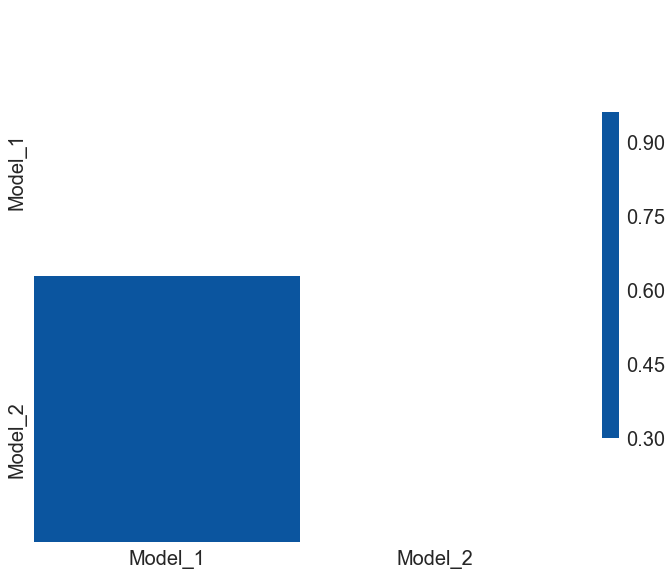

In [54]:
#append predictive models
ensemble_model = model_1_submission.copy()
ensemble_model.rename(index = str, columns = {'SalePrice' : 'Model_1'}, inplace = True)
ensemble_model['Model_2'] = model_2_submission.SalePrice.values
#ensemble_model['Model_3'] = model_3_submission.SalePrice.values
#ensemble_model['Model_4'] = model_4_submission.SalePrice.values
#ensemble_model['Model_5'] = model_5_submission.SalePrice.values


#evaluate correlation
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = 'white', font_scale = 2)

corr_matrix = ensemble_model.iloc[:,1:].corr()
mask = np.zeros_like(corr_matrix, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12,12))

cmap = sns.color_palette("Blues")

sns.heatmap(corr_matrix, mask = mask, cmap = cmap, vmax = .3, center = 0, 
           square = True, linewidths=.5, cbar_kws={'shrink': .5})

### Predicting SalePrice from an ensemble of predictive models

In [52]:
# take average
ensemble_model['SalePrice'] = ensemble_model.iloc[:,1:].mean(axis = 1)
# export csv
ensemble_model.head(3)

,Id,Model_1,Model_2,SalePrice
0,1461,110310.0,121733.0,116021.5
1,1462,155780.0,138031.0,146905.5
2,1463,189924.0,186544.0,188234.0


### Kaggle result
RMSE:  
Rank: 